In [129]:
import pandas as pd
import boto3
import awswrangler as wr
import numpy as np
from collections import Counter


import torch, torchtext
import torchvision.models as models
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader
from torchtext.vocab import GloVe
from torch import nn, optim

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
s3 = boto3.resource('s3')
buckets = [bucket.name for bucket in s3.buckets.all()]
print(buckets)

['godel-tf-state', 'godelsagemaker', 'sagemaker-eu-west-1-798631296162']


In [8]:
bucket = 'godelsagemaker'

chunks = wr.s3.read_csv(path=f's3://{bucket}/data/toxic_data.csv', chunksize=10000)
df = pd.concat(chunks)
df.head()

,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,0,2,0,0.373134,0.044776,0.089552,0.014925,0.000000,0.343284,0.014925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental hospitals. Boorah,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,1,2,0,0.605263,0.013158,0.065789,0.013158,0.092105,0.565789,0.065789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
2,5902188,And Trump continues his lifelong cowardice by not making this announcement himself.\n\nWhat an awful human being .....,train,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,2,3,7,0.666667,0.015873,0.031746,0.000000,0.047619,0.666667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63
3,7084460,"""while arresting a man for resisting arrest"".\n\nIf you cop-suckers can't see a problem with this, then go suck the barrel of a Glock.",test,2016-11-01 16:53:33.561631+00,13,NaN,149218,approved,0,0,0,0,0,0.815789,0.065789,0.552632,0.592105,0.000000,0.684211,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
4,5410943,Tucker and Paul are both total bad ass mofo's.,train,2017-06-14 05:08:21.997315+00,21,NaN,344096,approved,0,0,0,1,0,0.550000,0.037500,0.337500,0.275000,0.037500,0.487500,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80


In [105]:
# sample = df.sample(1_000_000)
sample = df
sample['comment_text'] = sample['comment_text'].fillna('')
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
for col in identity_columns + ['toxicity']:
    sample.loc[:, col] = np.where(sample[col] >= 0.5, True, False)

In [106]:
train_df = sample[sample['split'] == 'train']['comment_text']
test_df = sample[sample['split'] == 'test']['comment_text']



train_label = torch.tensor(sample[sample['split'] == 'train']['toxicity'].values, dtype=torch.float32).to(device)
test_label = torch.tensor(sample[sample['split'] == 'test']['toxicity'].values, dtype=torch.float32).to(device)

In [107]:
tokenizer = get_tokenizer("basic_english")
counter = Counter()
for line in train_df:
    counter.update(tokenizer(line))
    
# Create a vocabulary with words seen at least 3 (min_freq) times
vocab = torchtext.vocab.vocab(counter, min_freq=7)

In [108]:
# Add the unknown token and use it by default for unknown words
unk_token = '<unk>'
# vocab.insert_token(unk_token, 0)
vocab.set_default_index(0)

# Add the pad token Explanation https://huggingface.co/docs/transformers/pad_truncation
pad_token = '<pad>'
vocab.insert_token(pad_token, 1)

In [109]:
text_transform_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

In [110]:
print(f"Before transform:\t{train_df.iloc[666]}")
print(f"After transform:\t{text_transform_pipeline(train_df.iloc[666])}")

Before transform:	is it a loan or a hand out?  stupid Libs.  They need their buts kicked out.  Negligent and careless with our hard working tax dollars.  Wholly incompetent - kick em out of office.
After transform:	[116, 105, 70, 4548, 688, 70, 1731, 249, 168, 211, 429, 5, 28, 18, 231, 4549, 1337, 249, 5, 4550, 24, 3385, 288, 191, 529, 2801, 265, 488, 5, 4551, 187, 849, 3555, 255, 249, 22, 270, 5]


In [111]:
def transformText(text_list, max_len):
    # Transform the text
    transformed_data = [text_transform_pipeline(text)[:max_len] for text in text_list]

    # Pad zeros if the text is shoter than max_len
    for data in transformed_data:
        data[len(data) : max_len] = np.ones(max_len - len(data))

    return torch.tensor(transformed_data, dtype=torch.int64)

In [112]:
max_len = 100
batch_size = 8

# Pass transformed and padded data to dataset
# Create data loaders
train_dataset = TensorDataset(
    transformText(train_df, max_len), torch.tensor(train_label)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(transformText(test_df, max_len), torch.tensor(test_label))
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/tmp/ipykernel_156/3562846554.py:9: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(transformed_data, dtype=torch.int64)
/tmp/ipykernel_156/4086044940.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformText(train_df, max_len), torch.tensor(train_label)
/tmp/ipykernel_156/4086044940.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(transformText(test_df, max_len), torch.tensor(test_label))


In [113]:
#Pretrained Word Embeddings ====> GloVe, FastText, CharNGram

glove = GloVe(name="6B", dim=300)
embedding_matrix = glove.get_vecs_by_tokens(vocab.get_itos())

In [114]:
len(train_dataset)

1804875

In [115]:
embedding_matrix.shape

torch.Size([89307, 300])

In [116]:
# Size of the state vectors
hidden_size = 4

# General NN training parameters
learning_rate = 0.001
epochs = 5

# Embedding vector and vocabulary sizes
embed_size = 300  # glove.6B.300d.txt
vocab_size = len(vocab.get_itos())
vocab_size

89307

In [117]:
class Net(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(
            embed_size, hidden_size, num_layers=num_layers
        )

        self.linear = nn.Linear(hidden_size*max_len, 1)
        self.act = nn.Sigmoid()

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        # Call RNN layer
        outputs, _ = self.rnn(embeddings)
        # Use the output of each time step
        # Send it all together to the linear layer
        outs = self.linear(outputs.reshape(outputs.shape[0], -1))
        return self.act(outs)
    
model = Net(vocab_size, embed_size, hidden_size, num_layers=2)

# Initialize the weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.RNN:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
                
# We set the embedding layer's parameters from GloVe
model.embedding.weight.data.copy_(embedding_matrix)
# We won't change/train the embedding layer
model.embedding.weight.requires_grad = False

In [118]:
# Setting our trainer
trainer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# We will use Binary Cross-entropy loss
# reduction="sum" sums the losses for given output and target
cross_ent_loss = nn.BCELoss(reduction="sum")

In [119]:
train_losses = []
test_losses = []

# Get the compute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.apply(init_weights)
model.to(device)

for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    test_loss = 0
    # Training loop, train the network
    for data, target in train_loader:
        trainer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        L = cross_ent_loss(output.squeeze(1), target)
        training_loss += L.item()
        L.backward()
        trainer.step()

    # Validate the network, no training (no weight update)
    for data, target in test_loader:
        test_predictions = model(data.to(device))
        L = cross_ent_loss(test_predictions.squeeze(1), target.to(device))
        test_loss += L.item()

    # Let's take the average losses
    training_loss = training_loss / len(train_label)
    test_loss = test_loss / len(test_label)
    
    train_losses.append(training_loss)
    test_losses.append(test_loss)

    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss}. Test_loss {test_loss}. Seconds {end-start}"
    )

Epoch 0. Train_loss 0.04396630508173633. Test_loss 0.6442372899095615. Seconds 638.147787809372
Epoch 1. Train_loss 0.04178520445097279. Test_loss 0.6241383512080334. Seconds 637.007771730423
Epoch 2. Train_loss 0.03863704262095481. Test_loss 0.6122394452133338. Seconds 627.8964369297028
Epoch 3. Train_loss 0.03716284125921427. Test_loss 0.6071257315079781. Seconds 672.2014634609222
Epoch 4. Train_loss 0.036577652798293496. Test_loss 0.5918135334166661. Seconds 644.7643566131592


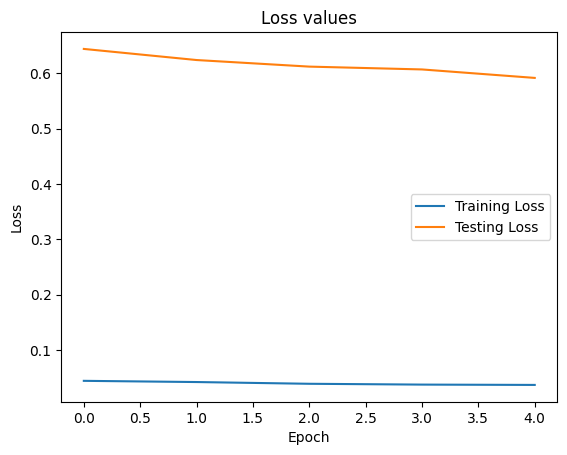

In [122]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [123]:
test_predictions = []
for data, target in test_loader:
    test_preds = model(data.to(device))
    test_predictions.extend(
        [np.rint(test_pred)[0] for test_pred in test_preds.detach().cpu().numpy()]
    )
print(test_predictions[:10])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [125]:
results = pd.DataFrame(columns=['model', 'accuracy', 'f1', 'roc_auc'])
acc_score = accuracy_score(test_label, test_predictions)
f1 = f1_score(test_label, test_predictions)
roc_auc = roc_auc_score(test_label, test_predictions)
results.loc[len(results)] = ["RNN", acc_score, f1, roc_auc]
results

,model,accuracy,f1,roc_auc
0,RNN,0.920633,0.0,0.5


In [130]:
model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

/home/studio-lab-user/.conda/envs/godel/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/godel/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/studio-lab-user/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]